In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy import nan 

from pyproj import Proj, Transformer
import geopandas as gp
from shapely.geometry import Point

import geopy.distance
from tqdm import tqdm

%matplotlib notebook

In [2]:
import sys,os
sys.path.append(os.getcwd())

# Start by creating a grid of (lat,lon) points covering an area more than California

In [3]:
n_lat = 500
n_lon = 500

lat_min = 32.32258176309383
lat_max = 42.0800848569942
lon_min = -124.687572099472
lon_max = -113.9228661436105

lats = np.linspace(lat_min,lat_max,n_lat)
lons = np.linspace(lon_min,lon_max,n_lon)

Lat_mesh,Lon_mesh = np.meshgrid(lats,lons)


LAT_LON = np.array(list(zip(Lat_mesh.ravel(), Lon_mesh.ravel()))).T

LAT = LAT_LON[0,:]
LON = LAT_LON[1,:]


grid_resolution = geopy.distance.geodesic((lats[0],lons[0]), (lats[0],lons[1])).km
print(f"Longitude Grid Resolution is {round(grid_resolution,2)} kms")
grid_resolution = geopy.distance.geodesic((lats[0],lons[0]), (lats[1],lons[0])).km
print(f"Latitude  Grid Resolution is {round(grid_resolution,2)} kms")

Longitude Grid Resolution is 2.03 kms
Latitude  Grid Resolution is 2.17 kms


# Plot the Grid Points

<IPython.core.display.Javascript object>


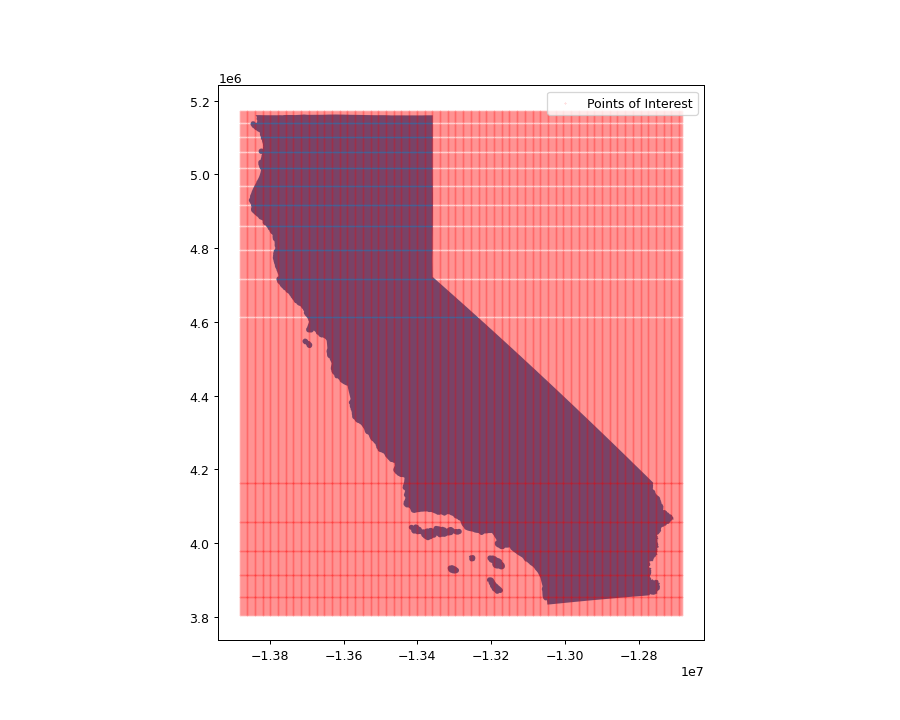

In [5]:
# Define the source and target EPSG codes
source_epsg = 'epsg:4326'  # WGS84
target_epsg = 'epsg:3857'  # Web Mercator

# Create Transformer
transformer = Transformer.from_crs(source_epsg, target_epsg)

# Transform the coordinates
grid_x, grid_y = transformer.transform(LAT, LON)


shapfile_path = './../data/california/CA_State_TIGER2016.shp'
gdf = gp.read_file(shapfile_path)


fig, ax = plt.subplots(figsize=(10, 8))

# Plot the GeoDataFrame on the specified axis
gdf.plot(ax=ax)

# Plot latitude and longitude points
plt.scatter(grid_x, grid_y, color='red', label='Points of Interest',s=.01)

# Show the plot
plt.legend()
plt.show()

# Restrict grid points to be within California

In [6]:
inside_CA_index = np.array([])

# Check if each pair of coordinates is within any shape
for ind,(x,y) in tqdm(enumerate(zip(grid_x, grid_y))):
    point = Point(x,y)
    is_within = gdf.geometry.contains(point)
    if is_within[0]:
        inside_CA_index = np.append(inside_CA_index,int(ind))

inside_CA_index = inside_CA_index.astype(int)

CA_grid_LAT = LAT[inside_CA_index]
CA_grid_LON = LON[inside_CA_index]

250000it [03:36, 1155.25it/s]


# Plot the restricted grid points

<IPython.core.display.Javascript object>


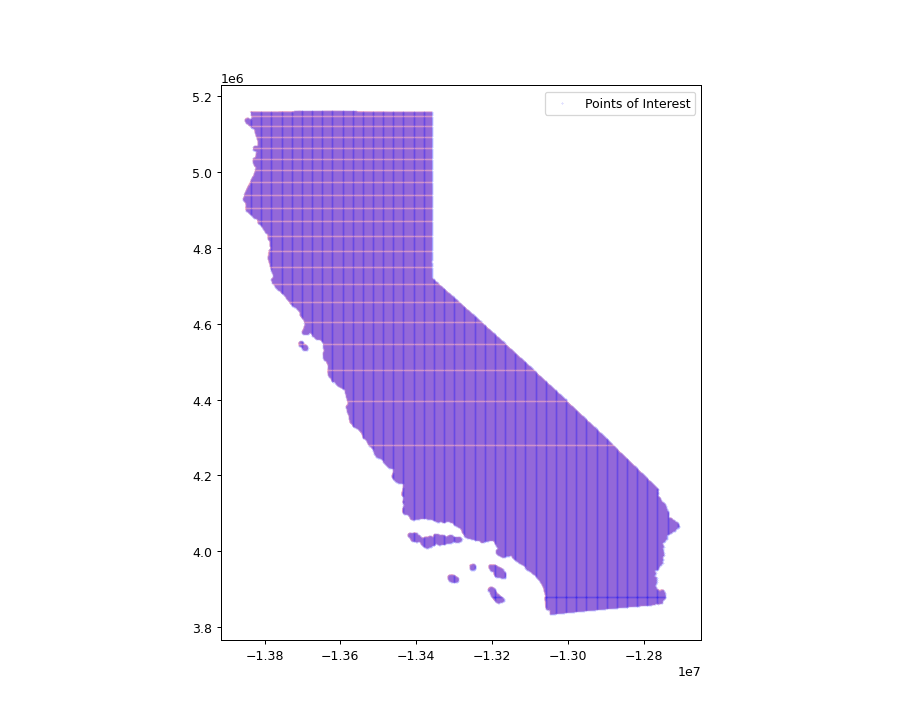

In [8]:
# Transform the coordinates
CA_grid_x, CA_grid_y = transformer.transform(CA_grid_LAT, CA_grid_LON)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot the GeoDataFrame on the specified axis
gdf.plot(ax=ax,color='lightpink')

# Plot latitude and longitude points
plt.scatter(CA_grid_x, CA_grid_y, color='blue', label='Points of Interest',s=.01)

# Show the plot
plt.legend()
plt.show()

# Load data from existing solar farms

In [9]:
data = pd.read_csv('./../data/US_solar_sites_2020_with_lat_lon_state_address.csv', index_col=False)
data = data.drop(columns='Unnamed: 0').reset_index(drop=True)
display(data.head(5))

Latitude   Longitude State  panel.area  power  panels  landscape.area  \
0  47.020475 -120.223217    WA    0.000141    NaN       1             0.0   
1  44.582129 -123.286963    OR    0.000141    NaN       1             0.0   
2  37.405176 -122.084769    CA    0.000141    NaN       1             0.0   
3  37.847173 -122.271529    CA    0.000141    NaN       1             0.0   
4  37.154450 -121.560230    CA    0.000141    NaN       1             0.0   

   water  urban                                            Address  
0      0      0                           2QCG+5P Renslow, WA, USA  
1      0      1     3230 NW Garfield Ave, Corvallis, OR 97330, USA  
2      0      1    1625 San Luis Ave, Mountain View, CA 94043, USA  
3      0      1  3372 Martin Luther King Jr Way, Berkeley, CA 9...  
4      0      0  16600 Finley Ridge Rd, Morgan Hill, CA 95037, USA

# Using only California Data

# Choosing only solar sites with panel area > 0.01 km^2 or (100m x 100m)

In [10]:
CA_data_all = data.copy()
CA_data_all = CA_data_all[CA_data_all['State']=='CA'].reset_index(drop=True)

cutoff = .01 # 0.01 km^2 : 100m x 100m
CA_data = CA_data_all.copy()
CA_data = CA_data[CA_data['panel.area']>=cutoff].reset_index(drop=True)
CA_data

Latitude   Longitude State  panel.area      power  panels  \
0    39.651116 -121.648247    CA    0.024364   1.765290      20   
1    35.651108 -120.710920    CA    0.011991   0.971455    1229   
2    35.656988 -120.596400    CA    0.010924   0.898075      66   
3    38.645396 -121.167424    CA    0.074268        NaN     125   
4    37.281723 -121.827189    CA    0.015024        NaN      86   
..         ...         ...   ...         ...        ...     ...   
224  34.654199 -118.283380    CA    0.916495  37.506222      16   
225  34.904225 -117.106231    CA    0.448031  20.522552       7   
226  34.549331 -117.466955    CA    0.058741   3.705283       4   
227  34.496376 -117.144202    CA    0.065647   4.069053       3   
228  34.511286 -117.387360    CA    0.114079   6.481718       5   

     landscape.area  water  urban  \
0          0.281727      0      0   
1          1.631422      0      0   
2          1.814945      0      0   
3          0.512284      0      1   
4          3.105102      0      1   
..              ...    ...    ...   
224        0.916495      0      0   
225        0.448031      0      0   
226        0.058741      0      0   
227        0.065647      0      0   
228        0.114079      0      0   

                                               Address  
0       Student Health Clinic, Oroville, CA 95965, USA  
1    3575 Mustang Springs Rd, Paso Robles, CA 93446...  
2               5625 CA-46, Paso Robles, CA 93446, USA  
3                              JRWM+52 Folsom, CA, USA  
4          4053 San Ramon Way, San Jose, CA 95111, USA  
..                                                 ...  
224                         MP38+MJ Lancaster, CA, USA  
225       25499 Community Blvd, Barstow, CA 92311, USA  
226                          GGXM+P6 Adelanto, CA, USA  
227     23755 Powhatan Rd, Apple Valley, CA 92307, USA  
228                       GJ67+G3 Victorville, CA, USA  

[229 rows x 10 columns]

# Plotting all solar sites and grid points

<IPython.core.display.Javascript object>


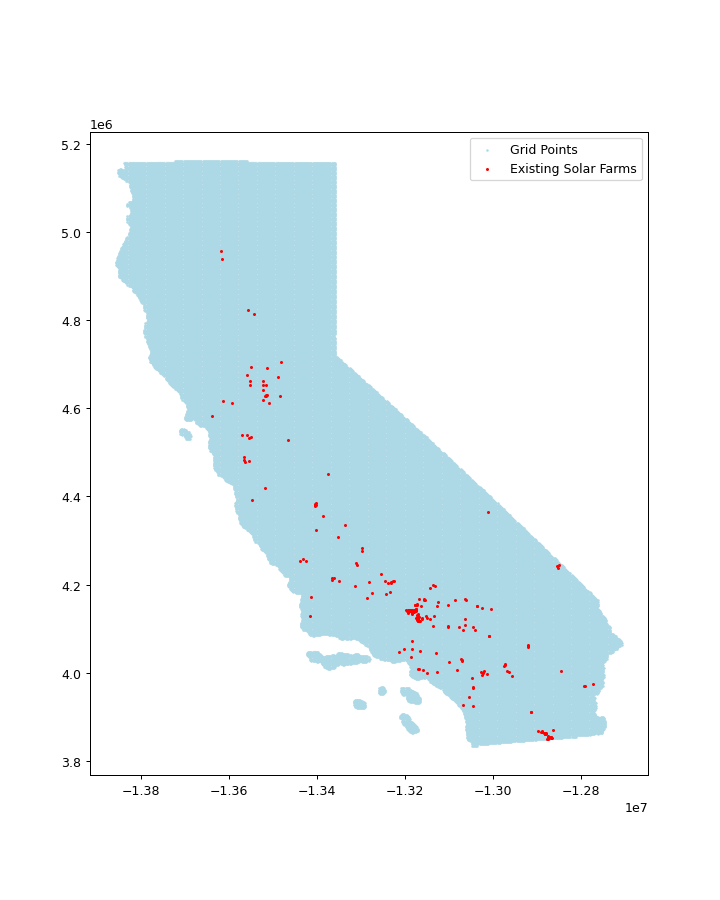

In [11]:
# Transform the coordinates
solar_site_lat = np.array(CA_data['Latitude'])
solar_site_lon = np.array(CA_data['Longitude'])
solar_site_x, solar_site_y = transformer.transform(solar_site_lat, solar_site_lon)

fig, ax = plt.subplots(figsize=(8, 10))

# Plot the GeoDataFrame on the specified axis
gdf.plot(ax=ax,color='#F5F5F5')

# Plot latitude and longitude points
plt.scatter(CA_grid_x   , CA_grid_y   , color='lightblue', label='Grid Points',s=1)
plt.scatter(solar_site_x, solar_site_y, color='red', label='Existing Solar Farms',s=2)

# Show the plot
plt.legend()
# plt.savefig('all_solar_sites_and_grid.pdf')
plt.show()

# Here we try to find the nearest grid point to a solar farm location and replace the solar farm with this grid point

# ---------- Load data from existing file if available ----------

In [ ]:
# filename = 'CA_data_version_0.csv'
# CA_grid = pd.read_csv(filename, index_col=False)

# display(CA_grid)
# display(CA_grid[CA_grid['Solar_farm_present']==1])

In [13]:
CA_grid = pd.DataFrame({'Latitude': CA_grid_LAT, 'Longitude':CA_grid_LON, 'Solar_farm_present':np.nan, 'State':np.nan,'panel.area':np.nan,'power':np.nan,'panels':np.nan,'landscape.area':np.nan,'water':np.nan,'urban':np.nan,'Address':np.nan  })

for i in tqdm(range(len(solar_site_lat))):
    coords_1 = (solar_site_lat[i],solar_site_lon[i])
    distances = np.array([])
    for j in tqdm(range(len(CA_grid_LAT))):
        coords_2 = (CA_grid_LAT[j],CA_grid_LON[j])
        distances = np.append(distances, geopy.distance.geodesic(coords_1, coords_2).km)
    
    CA_grid.at[np.argmin(distances),'Solar_farm_present'] = 1
    CA_grid.at[np.argmin(distances),'State']          = CA_data.at[i,'State']
    CA_grid.at[np.argmin(distances),'panel.area']     = CA_data.at[i,'panel.area']
    CA_grid.at[np.argmin(distances),'power']          = CA_data.at[i,'power']
    CA_grid.at[np.argmin(distances),'panels']         = CA_data.at[i,'panels']
    CA_grid.at[np.argmin(distances),'landscape.area'] = CA_data.at[i,'landscape.area']
    CA_grid.at[np.argmin(distances),'water']          = CA_data.at[i,'water']
    CA_grid.at[np.argmin(distances),'urban']          = CA_data.at[i,'urban']
    CA_grid.at[np.argmin(distances),'Address']        = CA_data.at[i,'Address']
    
display(CA_grid)
display(CA_grid[CA_grid['Solar_farm_present']==1])

 58%|███████████████▏          | 59659/102150 [00:10<00:08, 4997.97it/s]


100%|█████████████████████████| 102150/102150 [00:19<00:00, 5217.67it/s]
/tmp/ipykernel_47106/3130150349.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'CA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  CA_grid.at[np.argmin(distances),'State']          = CA_data.at[i,'State']
/tmp/ipykernel_47106/3130150349.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Student Health Clinic, Oroville, CA 95965, USA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  CA_grid.at[np.argmin(distances),'Address']        = CA_data.at[i,'Address']
  5%|█▎                         | 5006/102150 [00:00<00:18, 5340.03it/s]


 64%|████████████████▌         | 65247/102150 [00:11<00:07, 4904.01it/s]


 16%|████                      | 16151/102150 [00:02<00:16, 5351.57it/s]


 74%|███████████████████▎      | 75823/102150 [00:13<00:05, 5071.82it/s]


 29%|███████▍                  | 29200/102150 [00:05<00:11, 6313.29it/s]


 85%|██████████████████████    | 86890/102150 [00:16<00:03, 4729.90it/s]


 42%|██████████▉               | 42810/102150 [00:07<00:10, 5488.82it/s]


 95%|████████████████████████▋ | 97076/102150 [00:18<00:01, 4826.21it/s]


 53%|█████████████▊            | 54052/102150 [00:09<00:09, 5090.26it/s]


  6%|█▌                         | 5724/102150 [00:01<00:17, 5662.86it/s]


 65%|████████████████▉         | 66400/102150 [00:11<00:07, 5013.91it/s]


 18%|████▋                     | 18242/102150 [00:03<00:13, 6242.33it/s]


 75%|███████████████████▌      | 76835/102150 [00:14<00:05, 4957.32it/s]


 30%|███████▊                  | 30699/102150 [00:05<00:11, 6295.88it/s]


 86%|██████████████████████▍   | 88076/102150 [00:16<00:02, 4901.57it/s]


 43%|███████████▏              | 43750/102150 [00:07<00:10, 5658.40it/s]


 97%|█████████████████████████ | 98602/102150 [00:18<00:00, 4732.07it/s]


 55%|██████████████▎           | 56242/102150 [00:09<00:08, 5225.10it/s]


  6%|█▋                         | 6183/102150 [00:01<00:17, 5530.05it/s]


 66%|█████████████████         | 66953/102150 [00:11<00:06, 5117.85it/s]


 18%|████▋                     | 18621/102150 [00:03<00:15, 5550.45it/s]


 77%|████████████████████      | 78590/102150 [00:14<00:04, 5091.73it/s]


 30%|███████▊                  | 30814/102150 [00:05<00:13, 5399.93it/s]


 87%|██████████████████████▌   | 88427/102150 [00:16<00:02, 4585.21it/s]


 44%|███████████▌              | 45183/102150 [00:07<00:10, 5564.52it/s]


 98%|████████████████████████▌| 100114/102150 [00:18<00:00, 4138.18it/s]


 57%|██████████████▋           | 57802/102150 [00:10<00:08, 5308.99it/s]


 10%|██▌                        | 9775/102150 [00:01<00:16, 5713.99it/s]


 68%|█████████████████▋        | 69603/102150 [00:12<00:06, 4903.78it/s]


 23%|█████▉                    | 23249/102150 [00:04<00:12, 6470.02it/s]


 81%|█████████████████████     | 82587/102150 [00:14<00:03, 5023.83it/s]


 36%|█████████▎                | 36551/102150 [00:06<00:12, 5454.87it/s]


 92%|███████████████████████▉  | 93816/102150 [00:17<00:01, 4884.67it/s]


 47%|████████████▎             | 48213/102150 [00:08<00:10, 5387.04it/s]


  2%|▌                          | 2294/102150 [00:00<00:17, 5660.85it/s]


 59%|███████████████▏          | 59781/102150 [00:11<00:08, 4993.70it/s]


 14%|███▋                      | 14316/102150 [00:02<00:15, 5641.68it/s]


 72%|██████████████████▋       | 73208/102150 [00:13<00:04, 5882.39it/s]


 26%|██████▊                   | 26945/102150 [00:04<00:13, 5559.53it/s]


 83%|█████████████████████▍    | 84279/102150 [00:15<00:03, 5684.59it/s]


 40%|██████████▍               | 40825/102150 [00:07<00:11, 5448.25it/s]


 95%|████████████████████████▋ | 96903/102150 [00:18<00:00, 5476.47it/s]


 51%|█████████████▎            | 52276/102150 [00:09<00:09, 5225.66it/s]


  5%|█▍                         | 5521/102150 [00:01<00:17, 5548.52it/s]


 62%|████████████████▏         | 63477/102150 [00:11<00:07, 5075.32it/s]


 18%|████▌                     | 18109/102150 [00:03<00:16, 5096.54it/s]


 73%|██████████████████▉       | 74342/102150 [00:14<00:05, 5059.44it/s]


 29%|███████▍                  | 29160/102150 [00:05<00:14, 4977.19it/s]


 82%|█████████████████████▍    | 84267/102150 [00:16<00:03, 5175.03it/s]


 40%|██████████▍               | 40764/102150 [00:07<00:11, 5432.97it/s]


 96%|████████████████████████▊ | 97649/102150 [00:18<00:00, 5472.92it/s]


 54%|█████████████▉            | 54730/102150 [00:09<00:08, 5407.70it/s]


 10%|██▋                       | 10501/102150 [00:01<00:15, 5786.55it/s]


 69%|█████████████████▉        | 70309/102150 [00:12<00:05, 5903.45it/s]


 25%|██████▌                   | 25778/102150 [00:04<00:13, 5593.84it/s]


 83%|█████████████████████▋    | 84976/102150 [00:15<00:02, 5948.49it/s]


 40%|██████████▍               | 40849/102150 [00:07<00:11, 5481.57it/s]


 98%|█████████████████████████▍| 99864/102150 [00:18<00:00, 4486.35it/s]


 54%|██████████████▏           | 55576/102150 [00:10<00:08, 5342.02it/s]


 11%|██▊                       | 11053/102150 [00:01<00:15, 5718.05it/s]


 68%|█████████████████▌        | 69101/102150 [00:12<00:05, 5772.16it/s]


 20%|█████▏                    | 20506/102150 [00:03<00:14, 5539.00it/s]


 75%|███████████████████▌      | 76722/102150 [00:14<00:04, 5371.97it/s]


 31%|████████                  | 31811/102150 [00:05<00:13, 5336.43it/s]


 87%|██████████████████████▌   | 88548/102150 [00:16<00:02, 5655.32it/s]


 42%|██████████▊               | 42663/102150 [00:08<00:11, 5239.29it/s]


 98%|████████████████████████▌| 100323/102150 [00:18<00:00, 4446.41it/s]


 54%|██████████████            | 55049/102150 [00:10<00:08, 5430.35it/s]


 10%|██▌                        | 9788/102150 [00:01<00:16, 5722.07it/s]


 68%|█████████████████▋        | 69365/102150 [00:12<00:05, 5850.14it/s]


 24%|██████▎                   | 24896/102150 [00:04<00:13, 5666.89it/s]


 83%|█████████████████████▌    | 84576/102150 [00:15<00:03, 4958.82it/s]


 37%|█████████▌                | 37790/102150 [00:06<00:11, 5472.03it/s]


 94%|████████████████████████▎ | 95550/102150 [00:17<00:01, 4639.64it/s]


 48%|████████████▍             | 48889/102150 [00:09<00:11, 4576.82it/s]


100%|█████████████████████████| 102150/102150 [00:20<00:00, 4962.51it/s]


 53%|█████████████▊            | 54200/102150 [00:10<00:09, 5029.74it/s]


  6%|█▍                         | 5628/102150 [00:01<00:22, 4322.67it/s]


 59%|███████████████▎          | 60244/102150 [00:12<00:08, 4722.25it/s]


  9%|██▌                        | 9704/102150 [00:01<00:17, 5355.90it/s]


 63%|████████████████▍         | 64560/102150 [00:12<00:07, 4967.08it/s]


 17%|████▍                     | 17211/102150 [00:03<00:16, 5247.37it/s]


 71%|██████████████████▍       | 72374/102150 [00:14<00:06, 4814.05it/s]


 25%|██████▌                   | 25794/102150 [00:04<00:14, 5365.56it/s]


 80%|████████████████████▊     | 81573/102150 [00:15<00:04, 4899.03it/s]


 32%|████████▎                 | 32628/102150 [00:06<00:13, 5175.76it/s]


 86%|██████████████████████▎   | 87436/102150 [00:17<00:02, 5333.48it/s]


 38%|██████████                | 39302/102150 [00:07<00:13, 4577.14it/s]


 92%|███████████████████████▉  | 93950/102150 [00:18<00:01, 4861.55it/s]


 45%|███████████▌              | 45537/102150 [00:08<00:11, 4962.31it/s]


 97%|█████████████████████████▏| 99099/102150 [00:19<00:00, 3966.11it/s]


 50%|████████████▉             | 50772/102150 [00:10<00:10, 4986.68it/s]


  1%|▏                           | 554/102150 [00:00<00:18, 5530.87it/s]


 55%|██████████████▎           | 55994/102150 [00:11<00:09, 5001.40it/s]


  7%|█▉                         | 7363/102150 [00:01<00:17, 5352.09it/s]


 62%|████████████████▏         | 63635/102150 [00:12<00:07, 4986.37it/s]


 17%|████▍                     | 17440/102150 [00:03<00:15, 5416.07it/s]


 70%|██████████████████▏       | 71228/102150 [00:14<00:06, 5113.74it/s]


 22%|█████▊                    | 22812/102150 [00:04<00:15, 5212.54it/s]


 76%|███████████████████▋      | 77277/102150 [00:15<00:04, 5305.50it/s]


 28%|███████▏                  | 28429/102150 [00:05<00:14, 5133.49it/s]


 84%|█████████████████████▊    | 85544/102150 [00:16<00:03, 5025.38it/s]


 38%|█████████▊                | 38744/102150 [00:07<00:11, 5284.00it/s]


 92%|███████████████████████▊  | 93692/102150 [00:18<00:01, 5663.88it/s]


 47%|████████████▎             | 48400/102150 [00:09<00:10, 5256.72it/s]


  1%|▏                           | 580/102150 [00:00<00:17, 5798.29it/s]


 57%|██████████████▊           | 58347/102150 [00:10<00:08, 5136.12it/s]


 11%|██▉                       | 11383/102150 [00:02<00:16, 5652.99it/s]


 67%|█████████████████▌        | 68802/102150 [00:12<00:05, 5600.28it/s]


 21%|█████▍                    | 21388/102150 [00:04<00:15, 5249.88it/s]


 78%|████████████████████▏     | 79314/102150 [00:14<00:04, 5646.52it/s]


 32%|████████▎                 | 32700/102150 [00:05<00:12, 5376.22it/s]


 86%|██████████████████████▎   | 87603/102150 [00:16<00:02, 5430.87it/s]


 41%|██████████▋               | 42102/102150 [00:07<00:11, 5179.08it/s]


 96%|████████████████████████▉ | 97854/102150 [00:18<00:00, 4648.92it/s]


 50%|█████████████             | 51501/102150 [00:09<00:09, 5182.44it/s]


  1%|▎                          | 1074/102150 [00:00<00:18, 5385.48it/s]


 56%|██████████████▍           | 56879/102150 [00:11<00:08, 5096.12it/s]


  9%|██▎                        | 8905/102150 [00:01<00:17, 5450.71it/s]


 63%|████████████████▍         | 64371/102150 [00:12<00:07, 5196.53it/s]


 16%|████                      | 16049/102150 [00:03<00:16, 5152.57it/s]


 72%|██████████████████▋       | 73431/102150 [00:13<00:05, 5742.30it/s]


 26%|██████▋                   | 26230/102150 [00:04<00:16, 4699.46it/s]


 80%|████████████████████▊     | 81639/102150 [00:15<00:03, 5159.94it/s]


 34%|████████▋                 | 34313/102150 [00:06<00:12, 5396.32it/s]


 90%|███████████████████████▍  | 91959/102150 [00:17<00:02, 4974.32it/s]


 44%|███████████▌              | 45378/102150 [00:08<00:11, 5107.27it/s]


 99%|████████████████████████▊| 101231/102150 [00:19<00:00, 4218.37it/s]


 53%|█████████████▉            | 54580/102150 [00:10<00:10, 4376.60it/s]


  7%|█▊                         | 7057/102150 [00:01<00:17, 5367.25it/s]


 63%|████████████████▎         | 64206/102150 [00:12<00:07, 5373.90it/s]


 16%|████▏                     | 16616/102150 [00:03<00:16, 5289.00it/s]


 71%|██████████████████▎       | 72122/102150 [00:14<00:05, 5052.91it/s]


 25%|██████▍                   | 25303/102150 [00:04<00:16, 4581.00it/s]


 78%|████████████████████▎     | 79673/102150 [00:15<00:04, 5530.40it/s]


 34%|████████▊                 | 34436/102150 [00:06<00:12, 5325.99it/s]


 90%|███████████████████████▍  | 92100/102150 [00:17<00:02, 4857.55it/s]


 45%|███████████▊              | 46310/102150 [00:08<00:10, 5488.89it/s]


 99%|████████████████████████▊| 101251/102150 [00:19<00:00, 4086.95it/s]


 56%|██████████████▍           | 56932/102150 [00:10<00:08, 5120.99it/s]


  8%|██                         | 7898/102150 [00:01<00:16, 5630.88it/s]


 67%|█████████████████▎        | 68261/102150 [00:12<00:06, 5157.61it/s]


 21%|█████▌                    | 21954/102150 [00:03<00:13, 6129.14it/s]


 76%|███████████████████▋      | 77485/102150 [00:14<00:04, 4964.93it/s]


 30%|███████▉                  | 31008/102150 [00:05<00:12, 5770.25it/s]


 83%|█████████████████████▌    | 84862/102150 [00:16<00:03, 4734.45it/s]


 39%|██████████                | 39355/102150 [00:06<00:11, 5233.90it/s]


 88%|██████████████████████▉   | 90113/102150 [00:17<00:02, 4510.44it/s]


 40%|██████████▍               | 40994/102150 [00:07<00:11, 5278.09it/s]


 93%|████████████████████████▎ | 95441/102150 [00:18<00:01, 4669.43it/s]


 46%|████████████              | 47443/102150 [00:09<00:09, 5712.21it/s]


 99%|████████████████████████▊| 101390/102150 [00:20<00:00, 4160.36it/s]


 56%|██████████████▌           | 57154/102150 [00:10<00:08, 5369.08it/s]


  6%|█▌                         | 5693/102150 [00:01<00:19, 4836.74it/s]


 64%|████████████████▋         | 65611/102150 [00:12<00:07, 4707.90it/s]


 17%|████▌                     | 17853/102150 [00:02<00:13, 6447.14it/s]


 74%|███████████████████▏      | 75630/102150 [00:13<00:05, 4815.93it/s]


 30%|███████▊                  | 30686/102150 [00:05<00:12, 5579.77it/s]


 84%|█████████████████████▊    | 85465/102150 [00:16<00:03, 4932.87it/s]


 38%|█████████▊                | 38562/102150 [00:07<00:11, 5424.53it/s]


 93%|████████████████████████▎ | 95325/102150 [00:18<00:01, 4853.87it/s]


 47%|████████████▎             | 48147/102150 [00:09<00:09, 5792.18it/s]


 98%|████████████████████████▍| 100058/102150 [00:20<00:00, 3574.07it/s]


 51%|█████████████▎            | 52101/102150 [00:10<00:08, 5598.57it/s]


  2%|▍                          | 1584/102150 [00:00<00:19, 5179.36it/s]


 60%|███████████████▍          | 60816/102150 [00:11<00:07, 5301.77it/s]


 10%|██▋                       | 10383/102150 [00:01<00:16, 5432.52it/s]


 68%|█████████████████▋        | 69452/102150 [00:12<00:06, 4900.48it/s]


 21%|█████▌                    | 21732/102150 [00:03<00:13, 6028.40it/s]


 76%|███████████████████▊      | 77942/102150 [00:14<00:05, 4833.85it/s]


 28%|███████▏                  | 28293/102150 [00:05<00:16, 4564.21it/s]


 82%|█████████████████████▎    | 83738/102150 [00:16<00:04, 3767.21it/s]


 34%|████████▉                 | 35013/102150 [00:06<00:13, 5052.26it/s]


 86%|██████████████████████▎   | 87498/102150 [00:17<00:03, 4209.48it/s]


 37%|█████████▋                | 38131/102150 [00:07<00:11, 5535.86it/s]


 89%|███████████████████████▏  | 91261/102150 [00:18<00:02, 4775.09it/s]


 44%|███████████▍              | 44979/102150 [00:08<00:11, 4790.78it/s]


 93%|████████████████████████▏ | 95262/102150 [00:19<00:01, 4594.01it/s]


 49%|████████████▊             | 50260/102150 [00:09<00:10, 5122.00it/s]


100%|█████████████████████████| 102150/102150 [00:20<00:00, 5049.85it/s]


 54%|█████████████▉            | 54832/102150 [00:11<00:10, 4725.06it/s]


100%|█████████████████████████| 102150/102150 [00:22<00:00, 4587.24it/s]


 57%|██████████████▊           | 58028/102150 [00:10<00:08, 5121.30it/s]


  8%|██                         | 7900/102150 [00:01<00:16, 5592.87it/s]


 66%|█████████████████         | 66934/102150 [00:12<00:07, 4941.59it/s]


 16%|████▎                     | 16839/102150 [00:02<00:14, 5920.33it/s]


 70%|██████████████████▏       | 71544/102150 [00:13<00:06, 4580.16it/s]


 21%|█████▍                    | 21242/102150 [00:03<00:13, 5980.52it/s]


 75%|███████████████████▍      | 76166/102150 [00:14<00:05, 4409.26it/s]


 24%|██████▎                   | 24934/102150 [00:04<00:13, 5890.02it/s]


 78%|████████████████████▎     | 79914/102150 [00:15<00:04, 4845.34it/s]


 33%|████████▌                 | 33788/102150 [00:05<00:10, 6234.78it/s]


 88%|██████████████████████▊   | 89543/102150 [00:16<00:02, 4753.31it/s]


 44%|███████████▎              | 44572/102150 [00:07<00:10, 5341.13it/s]


 96%|█████████████████████████ | 98319/102150 [00:18<00:00, 4764.70it/s]


 52%|█████████████▌            | 53285/102150 [00:10<00:11, 4306.51it/s]


  3%|▊                          | 3309/102150 [00:00<00:17, 5555.98it/s]


 63%|████████████████▎         | 64033/102150 [00:11<00:07, 5092.84it/s]


 16%|████                      | 15915/102150 [00:02<00:14, 5868.60it/s]


 74%|███████████████████▎      | 76037/102150 [00:13<00:05, 5073.27it/s]


 30%|███████▉                  | 30998/102150 [00:05<00:11, 6307.01it/s]


 85%|██████████████████████    | 86750/102150 [00:16<00:03, 4876.01it/s]


 39%|██████████▏               | 39954/102150 [00:07<00:11, 5323.53it/s]


 95%|████████████████████████▋ | 97039/102150 [00:18<00:01, 4815.46it/s]


 49%|████████████▊             | 50560/102150 [00:09<00:10, 4764.41it/s]


  4%|█▏                         | 4544/102150 [00:00<00:17, 5592.36it/s]


 60%|███████████████▌          | 61231/102150 [00:11<00:08, 5080.62it/s]


 13%|███▎                      | 12805/102150 [00:02<00:16, 5503.32it/s]


 65%|████████████████▉         | 66569/102150 [00:13<00:08, 4049.27it/s]


 18%|████▋                     | 18252/102150 [00:03<00:15, 5390.11it/s]


 75%|███████████████████▍      | 76553/102150 [00:14<00:04, 5783.81it/s]


 29%|███████▌                  | 29612/102150 [00:05<00:13, 5301.13it/s]


 86%|██████████████████████▍   | 88095/102150 [00:16<00:02, 4921.55it/s]


 41%|██████████▋               | 41858/102150 [00:07<00:11, 5303.01it/s]


 96%|████████████████████████▉ | 97805/102150 [00:18<00:00, 4876.99it/s]


 51%|█████████████▏            | 51905/102150 [00:09<00:09, 5251.86it/s]


  4%|█▏                         | 4311/102150 [00:00<00:18, 5420.11it/s]


 59%|███████████████▎          | 60278/102150 [00:11<00:08, 5146.21it/s]


 13%|███▍                      | 13597/102150 [00:02<00:15, 5584.97it/s]


 68%|█████████████████▊        | 69785/102150 [00:13<00:06, 5121.90it/s]


 22%|█████▊                    | 22671/102150 [00:04<00:14, 5470.60it/s]


 77%|████████████████████      | 78796/102150 [00:14<00:04, 4957.28it/s]


 32%|████████▎                 | 32442/102150 [00:06<00:13, 5254.98it/s]


 84%|█████████████████████▊    | 85878/102150 [00:16<00:03, 4865.56it/s]


 38%|█████████▊                | 38632/102150 [00:07<00:13, 4661.62it/s]


 93%|████████████████████████▏ | 95097/102150 [00:18<00:01, 5007.25it/s]


 47%|████████████▏             | 47671/102150 [00:09<00:11, 4663.89it/s]


 99%|████████████████████████▊| 101278/102150 [00:20<00:00, 4445.97it/s]


 53%|█████████████▊            | 54079/102150 [00:10<00:10, 4541.95it/s]


  5%|█▎                         | 5089/102150 [00:00<00:17, 5574.19it/s]


 61%|███████████████▊          | 62040/102150 [00:11<00:07, 5053.55it/s]


 13%|███▍                      | 13734/102150 [00:02<00:17, 5168.11it/s]


 67%|█████████████████▎        | 68167/102150 [00:13<00:06, 4954.65it/s]


 19%|█████                     | 19652/102150 [00:03<00:14, 5527.90it/s]


 73%|███████████████████       | 74865/102150 [00:14<00:05, 4776.92it/s]


 26%|██████▊                   | 26566/102150 [00:05<00:15, 4979.75it/s]


 77%|███████████████████▉      | 78326/102150 [00:16<00:05, 4154.95it/s]


 28%|███████▍                  | 29087/102150 [00:05<00:14, 5078.30it/s]


 82%|█████████████████████▏    | 83334/102150 [00:16<00:03, 5548.59it/s]


 34%|████████▉                 | 34872/102150 [00:06<00:14, 4797.30it/s]


 85%|██████████████████████    | 86812/102150 [00:17<00:03, 5058.39it/s]


 39%|██████████▏               | 40264/102150 [00:07<00:11, 5219.29it/s]


 93%|████████████████████████▏ | 95017/102150 [00:18<00:01, 4714.10it/s]


 46%|███████████▊              | 46630/102150 [00:09<00:11, 5011.27it/s]


 98%|████████████████████████▌| 100487/102150 [00:20<00:00, 3813.37it/s]


 52%|█████████████▍            | 52959/102150 [00:10<00:09, 4972.51it/s]


  4%|█▏                         | 4430/102150 [00:00<00:17, 5513.92it/s]


 59%|███████████████▎          | 60148/102150 [00:11<00:08, 5098.39it/s]


 12%|███                       | 11904/102150 [00:02<00:17, 5224.42it/s]


 65%|████████████████▉         | 66462/102150 [00:13<00:07, 4625.13it/s]


 18%|████▋                     | 18392/102150 [00:03<00:15, 5287.93it/s]


 70%|██████████████████▎       | 71783/102150 [00:14<00:07, 4163.97it/s]


 23%|█████▉                    | 23483/102150 [00:04<00:15, 5055.11it/s]


 77%|████████████████████      | 78731/102150 [00:15<00:04, 5133.35it/s]


 28%|███████▎                  | 28848/102150 [00:05<00:15, 4608.67it/s]


 83%|█████████████████████▋    | 85023/102150 [00:16<00:03, 4845.01it/s]


 37%|█████████▌                | 37540/102150 [00:06<00:12, 5370.18it/s]


 92%|███████████████████████▉  | 94025/102150 [00:17<00:01, 4267.89it/s]


 46%|███████████▉              | 47105/102150 [00:08<00:10, 5188.06it/s]


  0%|                                        | 0/102150 [00:00<?, ?it/s]


 57%|██████████████▊           | 58232/102150 [00:10<00:08, 5350.17it/s]


 12%|███                       | 12039/102150 [00:02<00:15, 5664.31it/s]


 69%|█████████████████▊        | 70008/102150 [00:12<00:06, 5309.73it/s]


 24%|██████▏                   | 24107/102150 [00:04<00:14, 5502.88it/s]


 81%|█████████████████████▏    | 83064/102150 [00:15<00:03, 5198.75it/s]


 36%|█████████▎                | 36648/102150 [00:06<00:12, 5396.87it/s]


 92%|███████████████████████▉  | 94137/102150 [00:17<00:01, 4746.71it/s]


 46%|███████████▉              | 47039/102150 [00:09<00:10, 5321.69it/s]


100%|█████████████████████████| 102150/102150 [00:19<00:00, 5119.94it/s]


 56%|██████████████▌           | 56997/102150 [00:10<00:08, 5347.19it/s]


 11%|██▉                       | 11321/102150 [00:02<00:16, 5616.09it/s]


 66%|█████████████████▎        | 67885/102150 [00:12<00:05, 5743.53it/s]


 21%|█████▌                    | 21852/102150 [00:03<00:14, 5473.13it/s]


 77%|████████████████████      | 78879/102150 [00:14<00:04, 5635.83it/s]


 34%|████████▋                 | 34349/102150 [00:06<00:12, 5375.44it/s]


 90%|███████████████████████▌  | 92364/102150 [00:17<00:01, 4974.74it/s]


 46%|███████████▉              | 46758/102150 [00:08<00:10, 5284.49it/s]


  1%|▏                           | 536/102150 [00:00<00:18, 5356.74it/s]


 57%|██████████████▋           | 57771/102150 [00:10<00:08, 5253.51it/s]


 10%|██▋                       | 10638/102150 [00:01<00:16, 5585.91it/s]


 68%|█████████████████▌        | 68993/102150 [00:12<00:05, 5630.06it/s]


 22%|█████▌                    | 22095/102150 [00:04<00:14, 5359.51it/s]


 78%|████████████████████▍     | 80143/102150 [00:14<00:04, 5292.10it/s]


 32%|████████▍                 | 33181/102150 [00:06<00:12, 5309.45it/s]


 88%|██████████████████████▉   | 90266/102150 [00:16<00:02, 4824.96it/s]


 43%|███████████▏              | 43863/102150 [00:08<00:11, 5296.00it/s]


 98%|████████████████████████▌| 100552/102150 [00:18<00:00, 4265.36it/s]


 54%|██████████████            | 55182/102150 [00:10<00:08, 5313.56it/s]


  9%|██▍                        | 9008/102150 [00:01<00:16, 5560.66it/s]


 64%|████████████████▋         | 65730/102150 [00:12<00:06, 5753.06it/s]


 18%|████▊                     | 18674/102150 [00:03<00:15, 5324.66it/s]


 75%|███████████████████▍      | 76227/102150 [00:14<00:05, 4918.20it/s]


 28%|███████▍                  | 29078/102150 [00:05<00:14, 5115.44it/s]


 86%|██████████████████████▎   | 87719/102150 [00:16<00:03, 4788.89it/s]


 40%|██████████▍               | 41092/102150 [00:07<00:11, 5248.26it/s]


 96%|████████████████████████▉ | 97883/102150 [00:18<00:00, 4816.34it/s]


 50%|████████████▉             | 50690/102150 [00:09<00:10, 5083.43it/s]


  1%|▏                           | 557/102150 [00:00<00:18, 5563.10it/s]


 57%|██████████████▉           | 58490/102150 [00:10<00:08, 5395.97it/s]


 12%|███                       | 11920/102150 [00:02<00:16, 5528.41it/s]


 68%|█████████████████▌        | 69012/102150 [00:12<00:06, 5152.74it/s]


 23%|██████                    | 24005/102150 [00:04<00:14, 5473.21it/s]


 81%|█████████████████████▏    | 83102/102150 [00:15<00:03, 4999.28it/s]


 35%|█████████▏                | 36192/102150 [00:06<00:12, 5386.93it/s]


 93%|████████████████████████  | 94731/102150 [00:17<00:01, 4910.25it/s]


 48%|████████████▌             | 49456/102150 [00:09<00:09, 5294.87it/s]


  3%|▉                          | 3401/102150 [00:00<00:17, 5613.44it/s]


 60%|███████████████▋          | 61414/102150 [00:11<00:07, 5168.51it/s]


 16%|████▏                     | 16282/102150 [00:02<00:15, 5522.73it/s]


 71%|██████████████████▍       | 72587/102150 [00:13<00:05, 5431.24it/s]


 27%|███████                   | 27748/102150 [00:05<00:13, 5344.87it/s]


 85%|██████████████████████    | 86502/102150 [00:15<00:03, 4992.20it/s]


 38%|█████████▉                | 39194/102150 [00:07<00:11, 5369.86it/s]


 95%|████████████████████████▋ | 96939/102150 [00:18<00:01, 4907.66it/s]


 51%|█████████████▏            | 52039/102150 [00:09<00:08, 5617.78it/s]


  5%|█▍                         | 5600/102150 [00:01<00:17, 5608.58it/s]


 60%|███████████████▋          | 61783/102150 [00:11<00:07, 5108.75it/s]


 15%|███▊                      | 15079/102150 [00:02<00:15, 5558.78it/s]


 70%|██████████████████▏       | 71641/102150 [00:13<00:06, 5016.62it/s]


 24%|██████▎                   | 24649/102150 [00:04<00:14, 5502.82it/s]


 82%|█████████████████████▎    | 83614/102150 [00:15<00:03, 4922.84it/s]


 36%|█████████▍                | 37105/102150 [00:06<00:12, 5367.13it/s]


 93%|████████████████████████  | 94678/102150 [00:17<00:01, 4849.76it/s]


 48%|████████████▍             | 49057/102150 [00:08<00:09, 5500.90it/s]


  2%|▌                          | 2255/102150 [00:00<00:17, 5612.38it/s]


 59%|███████████████▎          | 60315/102150 [00:11<00:08, 5201.91it/s]


 11%|██▉                       | 11303/102150 [00:02<00:16, 5473.89it/s]


 67%|█████████████████▌        | 68779/102150 [00:12<00:06, 5082.05it/s]


 23%|██████                    | 23693/102150 [00:04<00:14, 5492.56it/s]


 79%|████████████████████▍     | 80216/102150 [00:14<00:04, 5190.56it/s]


 33%|████████▋                 | 33915/102150 [00:06<00:13, 5146.67it/s]


 87%|██████████████████████▌   | 88833/102150 [00:17<00:02, 5232.90it/s]


 42%|███████████               | 43319/102150 [00:08<00:11, 5292.96it/s]


 96%|█████████████████████████ | 98283/102150 [00:18<00:00, 5547.64it/s]


 52%|█████████████▍            | 52870/102150 [00:09<00:09, 5174.67it/s]


  6%|█▋                         | 6213/102150 [00:01<00:17, 5482.74it/s]


 61%|███████████████▉          | 62376/102150 [00:11<00:08, 4937.90it/s]


 15%|███▉                      | 15458/102150 [00:02<00:15, 5571.57it/s]


 70%|██████████████████▏       | 71357/102150 [00:13<00:06, 5068.95it/s]


 25%|██████▌                   | 25728/102150 [00:04<00:14, 5408.83it/s]


 79%|████████████████████▌     | 80647/102150 [00:15<00:04, 5026.09it/s]


 35%|█████████                 | 35403/102150 [00:06<00:12, 5385.24it/s]


 89%|███████████████████████▏  | 91102/102150 [00:17<00:02, 5411.10it/s]


 45%|███████████▊              | 46244/102150 [00:08<00:11, 5018.55it/s]


 98%|████████████████████████▌| 100160/102150 [00:19<00:00, 4313.10it/s]


 54%|██████████████            | 55176/102150 [00:10<00:08, 5657.17it/s]


  5%|█▎                         | 5080/102150 [00:00<00:17, 5629.37it/s]


 61%|███████████████▊          | 62295/102150 [00:11<00:07, 5194.26it/s]


 16%|████▏                     | 16692/102150 [00:03<00:15, 5452.54it/s]


 74%|███████████████████▏      | 75279/102150 [00:13<00:05, 5140.80it/s]


 28%|███████▎                  | 28498/102150 [00:05<00:14, 5221.58it/s]


 84%|█████████████████████▉    | 86134/102150 [00:15<00:03, 4974.00it/s]


 39%|██████████                | 39701/102150 [00:07<00:11, 5223.72it/s]


 95%|████████████████████████▊ | 97247/102150 [00:18<00:00, 4931.91it/s]


 51%|█████████████▏            | 51622/102150 [00:09<00:09, 5261.20it/s]


  6%|█▋                         | 6253/102150 [00:01<00:16, 5666.79it/s]


 62%|████████████████▏         | 63777/102150 [00:11<00:07, 5347.79it/s]


 18%|████▋                     | 18424/102150 [00:03<00:15, 5529.71it/s]


 74%|███████████████████       | 75083/102150 [00:14<00:05, 5097.52it/s]


 29%|███████▋                  | 30132/102150 [00:05<00:13, 5461.01it/s]


 86%|██████████████████████▍   | 88017/102150 [00:16<00:02, 5411.28it/s]


 41%|██████████▌               | 41530/102150 [00:07<00:11, 5279.02it/s]


 96%|█████████████████████████ | 98326/102150 [00:18<00:00, 4819.14it/s]


 53%|█████████████▊            | 54450/102150 [00:09<00:07, 6061.29it/s]


  7%|█▊                         | 6798/102150 [00:01<00:17, 5563.97it/s]


 61%|███████████████▉          | 62497/102150 [00:12<00:07, 5557.30it/s]


 17%|████▍                     | 17634/102150 [00:03<00:15, 5508.37it/s]


 75%|███████████████████▌      | 76820/102150 [00:13<00:04, 5404.13it/s]


 30%|███████▊                  | 30600/102150 [00:05<00:13, 5324.06it/s]


 87%|██████████████████████▋   | 88988/102150 [00:16<00:02, 4988.24it/s]


 42%|██████████▉               | 43087/102150 [00:07<00:11, 5317.80it/s]


 97%|█████████████████████████▎| 99273/102150 [00:18<00:00, 5216.23it/s]


 53%|█████████████▊            | 54399/102150 [00:10<00:09, 5183.07it/s]


  8%|██                         | 7913/102150 [00:01<00:16, 5621.89it/s]


 64%|████████████████▋         | 65500/102150 [00:12<00:06, 5856.63it/s]


 19%|████▊                     | 18955/102150 [00:03<00:15, 5415.41it/s]


 74%|███████████████████▏      | 75584/102150 [00:14<00:04, 5607.25it/s]


 28%|███████▎                  | 28544/102150 [00:05<00:13, 5375.52it/s]


 85%|██████████████████████▏   | 86936/102150 [00:16<00:03, 4984.98it/s]


 40%|██████████▎               | 40377/102150 [00:07<00:11, 5349.02it/s]


 95%|████████████████████████▋ | 97208/102150 [00:18<00:01, 4815.95it/s]


 50%|████████████▉             | 50878/102150 [00:09<00:09, 5355.41it/s]


  4%|█                          | 3940/102150 [00:00<00:17, 5580.85it/s]


 61%|███████████████▊          | 62236/102150 [00:11<00:06, 5880.54it/s]


 15%|████                      | 15833/102150 [00:02<00:15, 5509.75it/s]


 73%|███████████████████       | 74925/102150 [00:13<00:04, 5569.77it/s]


 27%|███████                   | 27696/102150 [00:05<00:13, 5381.21it/s]


 84%|█████████████████████▊    | 85759/102150 [00:15<00:03, 5076.35it/s]


 37%|█████████▋                | 38027/102150 [00:06<00:12, 5328.52it/s]


 94%|████████████████████████▎ | 95665/102150 [00:17<00:01, 4895.97it/s]


 48%|████████████▌             | 49248/102150 [00:09<00:10, 5194.60it/s]


  2%|▌                          | 2284/102150 [00:00<00:17, 5682.18it/s]


 57%|██████████████▊           | 57991/102150 [00:11<00:08, 5297.93it/s]


 12%|███                       | 11864/102150 [00:02<00:16, 5586.96it/s]


 68%|█████████████████▌        | 69076/102150 [00:12<00:05, 5847.66it/s]


 22%|█████▊                    | 22624/102150 [00:04<00:14, 5383.43it/s]


 79%|████████████████████▌     | 80586/102150 [00:14<00:03, 5440.30it/s]


 33%|████████▋                 | 33899/102150 [00:06<00:12, 5286.16it/s]


 89%|███████████████████████▎  | 91414/102150 [00:17<00:02, 4816.69it/s]


 43%|███████████▎              | 44309/102150 [00:08<00:11, 5203.52it/s]


 99%|████████████████████████▊| 101481/102150 [00:19<00:00, 4239.58it/s]


 56%|██████████████▍           | 56746/102150 [00:10<00:08, 5289.84it/s]


 11%|██▊                       | 11264/102150 [00:02<00:16, 5589.69it/s]


 68%|█████████████████▋        | 69464/102150 [00:12<00:05, 5869.21it/s]


 23%|█████▉                    | 23471/102150 [00:04<00:14, 5465.22it/s]


 80%|████████████████████▊     | 81879/102150 [00:14<00:03, 5293.27it/s]


 35%|█████████                 | 35446/102150 [00:06<00:12, 5349.80it/s]


 91%|███████████████████████▋  | 93047/102150 [00:17<00:01, 4849.73it/s]


 46%|███████████▉              | 46723/102150 [00:08<00:10, 5204.87it/s]


  0%|                                        | 0/102150 [00:00<?, ?it/s]


 57%|██████████████▊           | 58159/102150 [00:10<00:08, 5115.34it/s]


 13%|███▎                      | 12834/102150 [00:02<00:15, 5593.99it/s]


 69%|█████████████████▊        | 70093/102150 [00:13<00:05, 5377.77it/s]


 25%|██████▎                   | 25038/102150 [00:04<00:14, 5439.90it/s]


 80%|████████████████████▊     | 81800/102150 [00:15<00:03, 5794.56it/s]


 36%|█████████▍                | 36952/102150 [00:06<00:12, 5168.93it/s]


 93%|████████████████████████  | 94528/102150 [00:17<00:01, 5006.44it/s]


100%|███████████████████████████████| 229/229 [1:15:21<00:00, 19.74s/it]


Latitude   Longitude  Solar_farm_present State  panel.area  power  \
0       40.417985 -124.471847                 NaN   NaN         NaN    NaN   
1       40.437539 -124.471847                 NaN   NaN         NaN    NaN   
2       40.457093 -124.471847                 NaN   NaN         NaN    NaN   
3       40.398431 -124.450274                 NaN   NaN         NaN    NaN   
4       40.417985 -124.450274                 NaN   NaN         NaN    NaN   
...           ...         ...                 ...   ...         ...    ...   
102145  34.277993 -114.160164                 NaN   NaN         NaN    NaN   
102146  34.297547 -114.160164                 NaN   NaN         NaN    NaN   
102147  34.317101 -114.160164                 NaN   NaN         NaN    NaN   
102148  34.258439 -114.138592                 NaN   NaN         NaN    NaN   
102149  34.277993 -114.138592                 NaN   NaN         NaN    NaN   

        panels  landscape.area  water  urban Address  
0          NaN             NaN    NaN    NaN     NaN  
1          NaN             NaN    NaN    NaN     NaN  
2          NaN             NaN    NaN    NaN     NaN  
3          NaN             NaN    NaN    NaN     NaN  
4          NaN             NaN    NaN    NaN     NaN  
...        ...             ...    ...    ...     ...  
102145     NaN             NaN    NaN    NaN     NaN  
102146     NaN             NaN    NaN    NaN     NaN  
102147     NaN             NaN    NaN    NaN     NaN  
102148     NaN             NaN    NaN    NaN     NaN  
102149     NaN             NaN    NaN    NaN     NaN  

[102150 rows x 11 columns]

Latitude   Longitude  Solar_farm_present State  panel.area  \
13910   38.032383 -122.508744                 1.0    CA    0.019112   
16288   40.633080 -122.314591                 1.0    CA    0.026765   
16536   40.496202 -122.293018                 1.0    CA    0.014312   
16678   38.267033 -122.271446                 1.0    CA    0.034076   
18748   38.227924 -122.098865                 1.0    CA    0.032722   
...           ...         ...                 ...   ...         ...   
96540   35.588119 -115.432945                 1.0    CA    5.889066   
96753   33.828249 -115.389800                 1.0    CA   14.031455   
99819   33.574045 -114.915204                 1.0    CA    0.308603   
99948   33.574045 -114.893631                 1.0    CA    0.033762   
100825  33.593599 -114.742623                 1.0    CA    0.814060   

             power  panels  landscape.area  water  urban  \
13910     1.438727     6.0        0.019112    0.0    0.0   
16288     1.910786   702.0        0.026765    0.0    0.0   
16536     1.127613     3.0        0.014312    0.0    0.0   
16678          NaN     3.0        0.034076    0.0    1.0   
18748     2.263317     4.0        0.032722    0.0    0.0   
...            ...     ...             ...    ...    ...   
96540   179.797992     6.0        5.889066    0.0    0.0   
96753   373.646009     6.0       14.031455    0.0    0.0   
99819          NaN     3.0        0.308603    0.0    1.0   
99948          NaN     3.0        0.033762    0.0    1.0   
100825   33.941913     4.0        0.814060    0.0    0.0   

                                        Address  
13910               2FJV+G3 San Rafael, CA, USA  
16288        JMJJ+R4 Columbia, Redding, CA, USA  
16536   6759 Airport Rd, Redding, CA 96002, USA  
16678                     7PCC+W7 Napa, CA, USA  
18748                6WJ4+QW Fairfield, CA, USA  
...                                         ...  
96540                   HHP8+27 Calada, CA, USA  
96753            RJ96+C8 Desert Center, CA, USA  
99819                   H38J+CM Blythe, CA, USA  
99948                   H38W+3C Blythe, CA, USA  
100825              H7R3+PP Mesa Verde, CA, USA  

[207 rows x 11 columns]

# Plot the new grid that includes solar site information
# Save data

<IPython.core.display.Javascript object>


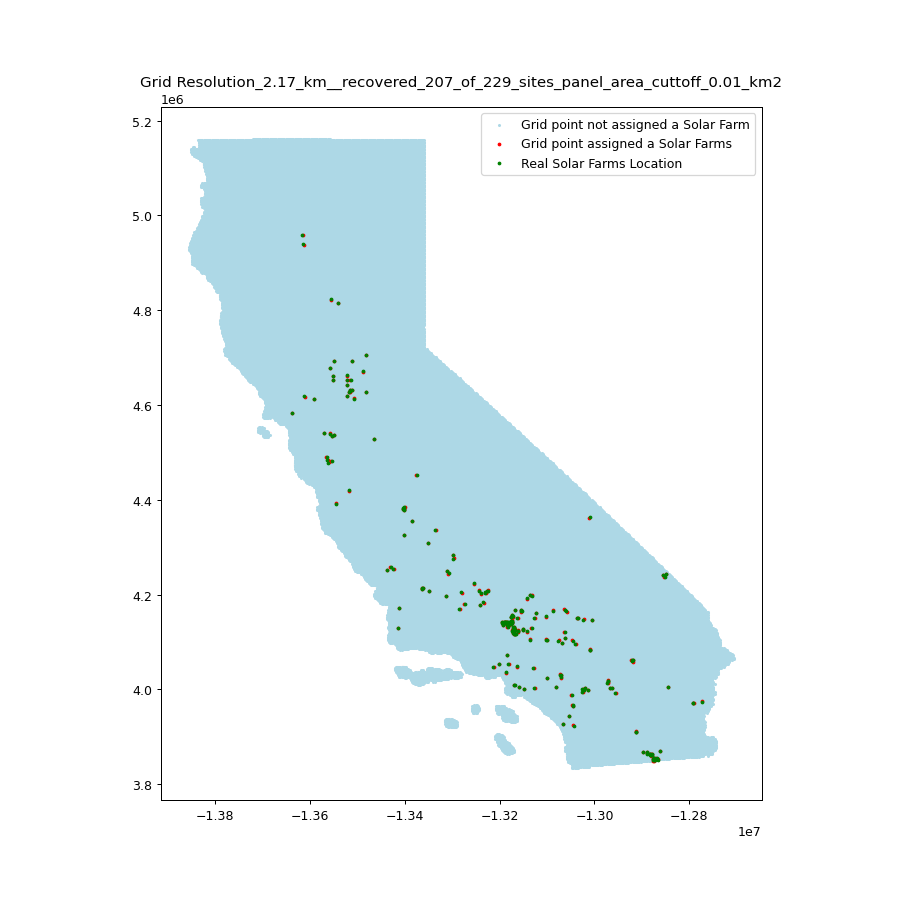

In [16]:
# Transform the coordinates
solar_site_1_lat = np.array(np.array(CA_grid[CA_grid['Solar_farm_present']==1]['Latitude']))
solar_site_1_lon = np.array(np.array(CA_grid[CA_grid['Solar_farm_present']==1]['Longitude']))
solar_site_1_x, solar_site_1_y = transformer.transform(solar_site_1_lat, solar_site_1_lon)

solar_site_nan_lat = np.array(np.array(CA_grid[CA_grid['Solar_farm_present']!=1]['Latitude']))
solar_site_nan_lon = np.array(np.array(CA_grid[CA_grid['Solar_farm_present']!=1]['Longitude']))
solar_site_nan_x, solar_site_nan_y = transformer.transform(solar_site_nan_lat, solar_site_nan_lon)

solar_site_real_lat = np.array(np.array(CA_data['Latitude']))
solar_site_real_lon = np.array(np.array(CA_data['Longitude']))
solar_site_real_x, solar_site_real_y = transformer.transform(solar_site_real_lat, solar_site_real_lon)

fig, ax = plt.subplots(figsize=(10,10))

# Plot the GeoDataFrame on the specified axis
gdf.plot(ax=ax,color='#F5F5F5')

plt.scatter(solar_site_nan_x, solar_site_nan_y   , color='lightblue', label='Grid point not assigned a Solar Farm',s=2)
plt.scatter(solar_site_1_x  , solar_site_1_y     , color='red'  , label='Grid point assigned a Solar Farms'    ,s=4)
plt.scatter(solar_site_real_x, solar_site_real_y , color='green', label='Real Solar Farms Location'       ,s=4)

# Show the plot
sites_recovered = len(CA_grid[CA_grid['Solar_farm_present']==1])
total_sites = len(CA_data)
name = f'Grid Resolution_{round(grid_resolution,2)}_km__recovered_{sites_recovered}_of_{total_sites}_sites_panel_area_cuttoff_{cutoff}_km2'
plt.title(name)
plt.legend()
plt.savefig(f'{name}.pdf')
plt.show()

# Save data
CA_grid.to_csv(f"{name}.csv",index=False)

# Minor changes to data

In [30]:
# Save all states as "CA"
CA_grid['State'] = 'CA'

# Save data with different name
CA_grid.to_csv(f"CA_data_version_0.csv",index=False)

In [31]:
display(CA_grid.head(10))

display(CA_grid[test['Solar_farm_present']==1].head(10))

Latitude   Longitude  Solar_farm_present State  panel.area  power  panels  \
0  40.417985 -124.471847                 NaN    CA         NaN    NaN     NaN   
1  40.437539 -124.471847                 NaN    CA         NaN    NaN     NaN   
2  40.457093 -124.471847                 NaN    CA         NaN    NaN     NaN   
3  40.398431 -124.450274                 NaN    CA         NaN    NaN     NaN   
4  40.417985 -124.450274                 NaN    CA         NaN    NaN     NaN   
5  40.437539 -124.450274                 NaN    CA         NaN    NaN     NaN   
6  40.457093 -124.450274                 NaN    CA         NaN    NaN     NaN   
7  40.476647 -124.450274                 NaN    CA         NaN    NaN     NaN   
8  40.496202 -124.450274                 NaN    CA         NaN    NaN     NaN   
9  40.515756 -124.450274                 NaN    CA         NaN    NaN     NaN   

   landscape.area  water  urban Address  
0             NaN    NaN    NaN     NaN  
1             NaN    NaN    NaN     NaN  
2             NaN    NaN    NaN     NaN  
3             NaN    NaN    NaN     NaN  
4             NaN    NaN    NaN     NaN  
5             NaN    NaN    NaN     NaN  
6             NaN    NaN    NaN     NaN  
7             NaN    NaN    NaN     NaN  
8             NaN    NaN    NaN     NaN  
9             NaN    NaN    NaN     NaN

Latitude   Longitude  Solar_farm_present State  panel.area     power  \
13910  38.032383 -122.508744                 1.0    CA    0.019112  1.438727   
16288  40.633080 -122.314591                 1.0    CA    0.026765  1.910786   
16536  40.496202 -122.293018                 1.0    CA    0.014312  1.127613   
16678  38.267033 -122.271446                 1.0    CA    0.034076       NaN   
18748  38.227924 -122.098865                 1.0    CA    0.032722  2.263317   
21257  37.719517 -121.904712                 1.0    CA    0.028839       NaN   
21833  37.367543 -121.861567                 1.0    CA    0.015607       NaN   
22129  37.328435 -121.839995                 1.0    CA    0.012047       NaN   
22425  37.289327 -121.818422                 1.0    CA    0.015024       NaN   
22746  37.719517 -121.796849                 1.0    CA    0.020979  1.556256   

       panels  landscape.area  water  urban  \
13910     6.0        0.019112    0.0    0.0   
16288   702.0        0.026765    0.0    0.0   
16536     3.0        0.014312    0.0    0.0   
16678     3.0        0.034076    0.0    1.0   
18748     4.0        0.032722    0.0    0.0   
21257     5.0        0.030839    0.0    1.0   
21833    72.0        0.229024    0.0    1.0   
22129    81.0        1.470642    0.0    1.0   
22425    86.0        3.105102    0.0    1.0   
22746     9.0        0.020979    0.0    0.0   

                                            Address  
13910                   2FJV+G3 San Rafael, CA, USA  
16288            JMJJ+R4 Columbia, Redding, CA, USA  
16536       6759 Airport Rd, Redding, CA 96002, USA  
16678                         7PCC+W7 Napa, CA, USA  
18748                    6WJ4+QW Fairfield, CA, USA  
21257                       P3GR+8Q Dublin, CA, USA  
21833    617 N Jackson Ave, San Jose, CA 95133, USA  
22129  968 Chapel Hill Way, San Jose, CA 95122, USA  
22425   4053 San Ramon Way, San Jose, CA 95111, USA  
22746                    P663+QX Livermore, CA, USA